In [21]:
from __future__ import print_function, division

from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
CUDA_LAUNCH_BLOCKING=1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
# folder_name = 'agdhi'
# target=['variety_A','variety_B','variety_C','variety_D','variety_E','variety_F']

# for category in target:
#     path=os.path.join(folder_name, category)
#     ar = []
#     for img in os.listdir(path):
#         ar.append(os.path.join(path,img))
#     print((ar))
device

device(type='cuda', index=0)

In [48]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
CUDA_LAUNCH_BLOCKING=1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


input_path = "agdhi"
# normalize images to remove noise
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# transform the images into a particular format and convert to tensors
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

#  load images from agdhi
image_datasets = {
    'train': 
    datasets.ImageFolder(input_path, data_transforms['train']),
    'val': 
    datasets.ImageFolder(input_path, data_transforms['val'])
}

# split into training and testing sets
tr_sz = int(len(image_datasets['train'])*0.8)
te_sz = len(image_datasets['train']) - tr_sz

train_set, val_set = torch.utils.data.random_split(image_datasets['train'], [tr_sz, te_sz])

# convert them into the format which pytorxh natively uses
dataloaders = {
    'train':
    torch.utils.data.DataLoader(train_set,
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle,
    'val':
    torch.utils.data.DataLoader(val_set,
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)
}

class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# dataset_sizes, class_names
sizes = { 'train':len(train_set), 'val':len(val_set)} 
len(train_set), len(val_set)

(52265, 13067)

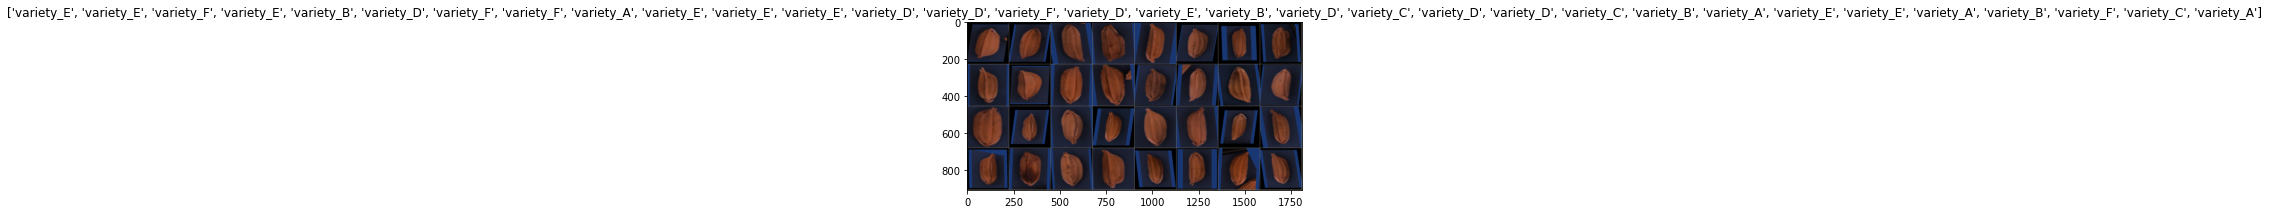

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# this is used in final layer values to convert the values into probabilistic values
softmax = nn.Softmax()

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
#         for phase in ['val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels - 1

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                
                if phase == 'train':
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     #_, preds = torch.max(outputs, 1)

#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':  
                        
                preds = torch.max(softmax(outputs), 1).indices
                
                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                    
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / sizes[phase]
            epoch_acc = running_corrects.double() / sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        


In [7]:
#  took pretrained resnet model
model_ft = models.resnet18(pretrained=True)
# appended fully connecrted layer to the final layer of resnet
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)
# then we trained on the entire training dataset and backpropagated the values thorughout the entire model
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------


100%|██████████| 1634/1634 [05:02<00:00,  5.39it/s]


train Loss: 0.0146 Acc: 0.8129


100%|██████████| 409/409 [00:55<00:00,  7.32it/s]


val Loss: 0.0081 Acc: 0.8997
Epoch 1/11
----------


100%|██████████| 1634/1634 [05:03<00:00,  5.39it/s]


train Loss: 0.0081 Acc: 0.8999


100%|██████████| 409/409 [00:56<00:00,  7.29it/s]


val Loss: 0.0068 Acc: 0.9141
Epoch 2/11
----------


100%|██████████| 1634/1634 [05:02<00:00,  5.40it/s]


train Loss: 0.0066 Acc: 0.9181


100%|██████████| 409/409 [00:55<00:00,  7.31it/s]


val Loss: 0.0062 Acc: 0.9222
Epoch 3/11
----------


100%|██████████| 1634/1634 [05:03<00:00,  5.38it/s]


train Loss: 0.0057 Acc: 0.9306


100%|██████████| 409/409 [00:55<00:00,  7.34it/s]


val Loss: 0.0057 Acc: 0.9298
Epoch 4/11
----------


100%|██████████| 1634/1634 [05:03<00:00,  5.39it/s]


train Loss: 0.0051 Acc: 0.9392


100%|██████████| 409/409 [00:56<00:00,  7.30it/s]


val Loss: 0.0048 Acc: 0.9418
Epoch 5/11
----------


100%|██████████| 1634/1634 [05:09<00:00,  5.28it/s]


train Loss: 0.0046 Acc: 0.9444


100%|██████████| 409/409 [00:55<00:00,  7.31it/s]


val Loss: 0.0052 Acc: 0.9378
Epoch 6/11
----------


100%|██████████| 1634/1634 [05:09<00:00,  5.28it/s]


train Loss: 0.0042 Acc: 0.9509


100%|██████████| 409/409 [00:56<00:00,  7.29it/s]


val Loss: 0.0037 Acc: 0.9557
Epoch 7/11
----------


100%|██████████| 1634/1634 [05:08<00:00,  5.30it/s]


train Loss: 0.0032 Acc: 0.9625


100%|██████████| 409/409 [00:55<00:00,  7.33it/s]


val Loss: 0.0032 Acc: 0.9623
Epoch 8/11
----------


100%|██████████| 1634/1634 [05:07<00:00,  5.32it/s]


train Loss: 0.0029 Acc: 0.9659


100%|██████████| 409/409 [00:56<00:00,  7.30it/s]


val Loss: 0.0032 Acc: 0.9603
Epoch 9/11
----------


100%|██████████| 1634/1634 [05:03<00:00,  5.38it/s]


train Loss: 0.0028 Acc: 0.9669


100%|██████████| 409/409 [00:57<00:00,  7.17it/s]


val Loss: 0.0031 Acc: 0.9635
Epoch 10/11
----------


100%|██████████| 1634/1634 [05:11<00:00,  5.24it/s]


train Loss: 0.0027 Acc: 0.9685


100%|██████████| 409/409 [00:55<00:00,  7.33it/s]


val Loss: 0.0032 Acc: 0.9612
Epoch 11/11
----------


100%|██████████| 1634/1634 [05:11<00:00,  5.24it/s]


train Loss: 0.0027 Acc: 0.9695


100%|██████████| 409/409 [00:57<00:00,  7.16it/s]


val Loss: 0.0031 Acc: 0.9636
Training complete in 72m 31s
Best val Acc: 0.963572


In [9]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

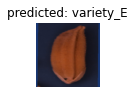

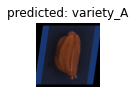

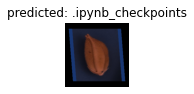

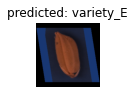

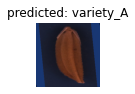

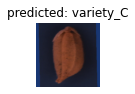

In [10]:
visualize_model(model_ft)
plt.ioff()
plt.show()

In [14]:
#  saves the model so that we need not retrain it
torch.save(model_ft, 'complete_model_ft.pth')


In [ ]:
# model_conv = torchvision.models.resnet18(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 6)

# model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that only parameters of final layer are being optimized as
# # opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25)

In [15]:
#  load the model which jas been a,ready trained
model = torch.load('complete_model_ft.pth')
#  switch the model to evaluation model
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
model_ft_eval = models.resnet18(pretrained=True)
num_ftrs = model_ft_eval.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_eval.fc = nn.Linear(num_ftrs, 6)

model_ft_eval = model_ft_eval.to(device)

model_ft_eval.load_state_dict(torch.load('model_ft.pth'))
model_ft_eval.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
for inputs, labels in tqdm(dataloaders['val']):
    inputs, labels = inputs.cuda(), labels.cuda()
    print(inputs.shape)
    print(model_ft_eval(inputs))
    break

  0%|          | 0/409 [00:00<?, ?it/s]

torch.Size([32, 3, 224, 224])
tensor([[-3.9888e+00, -3.1480e+00,  8.3102e-01, -7.2832e+00,  6.8532e-01,
          1.2371e+01],
        [ 4.4092e+00,  6.8230e+00,  3.5749e+00, -7.8467e+00, -6.1618e+00,
         -2.0218e+00],
        [ 9.9959e+00,  2.0285e+00,  4.0590e+00, -3.9628e+00, -5.6765e+00,
         -6.1974e+00],
        [-8.7114e+00, -5.3754e+00, -1.1377e+00, -4.8591e-01,  2.3934e+00,
          1.2259e+01],
        [ 2.9707e+00,  8.1377e+00,  3.6841e+00, -5.3904e+00, -6.0914e+00,
         -3.9729e+00],
        [-4.4387e+00, -5.6786e+00,  8.2714e-01,  1.0100e+01, -1.9153e+00,
         -6.8153e-01],
        [ 8.4660e+00,  4.2156e+00,  7.0094e+00, -6.8759e+00, -5.7593e+00,
         -7.2469e+00],
        [-9.2692e-01, -5.5105e+00,  2.9958e+00,  6.7314e+00, -1.3697e+00,
         -3.7887e+00],
        [-4.1104e+00, -4.7344e+00,  1.5430e+00, -7.5976e+00,  3.5127e+00,
          1.1444e+01],
        [ 3.2254e+00, -4.2618e-01,  6.5283e+00, -2.4113e+00, -6.2343e+00,
         -9.7588e-01],


In [25]:
ls

1.ipynb                          model_image_classifier.ipynb
agdhi/                           model_logistic_regression.ipynb
complete_model_ft.pth            not_working_cnn_resnet9.ipynb
Final_ML_model_classifier.ipynb  Shubham.ipynb
image_classifier/                Tensorflow_87_accuracy.ipynb
iris.csv                         test_notebook.ipynb
lost+found/                      tf_model/
model_ft.pth                     trial.ipynb


In [28]:
cp agdhi/variety_B/img_1628221264073.jpg_ext0.jpg .

In [ ]:
# 4073 for class b
# img_1628240919931.jpg_ext0.jpg class E


In [45]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

def infer(image_path):
    img = read_image(image_path)

    img = T.ToPILImage()(img)
    img.show()

    x = data_transforms['train']
    tensor = x(img)
    tensor = tensor.unsqueeze(0) 
    tensor = tensor.cuda()
    softmax = nn.Softmax()
    outputs = model_ft_eval(tensor)
    preds = torch.max(softmax(outputs), 1).indices
    class_mapping = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F'}
    print("The image belongs to class", class_mapping[preds.item()])

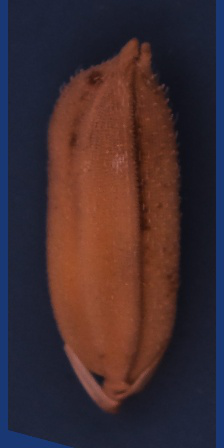

The image belongs to class E


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [47]:
infer('img_1628240919931.jpg_ext0.jpg')